In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

# generate training and testing data

In [4]:
def gen_data(x):
    y = x * np.sin(x*10) + 1 
    y += np.random.uniform(0, 0.1, size=(len(y)))
    return y

In [5]:
# generate some fake data
x = np.linspace(-1, 1, 100)
# x = x[::6]
y = gen_data(x)

x = x.reshape(-1, 1)

In [6]:
# validation data
x_val = np.arange(-1, 1, 0.001)
y_val = gen_data(x_val)

x_val = x_val.reshape(-1, 1)

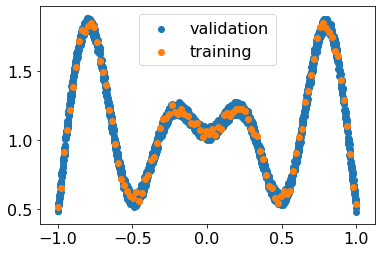

In [7]:
plt.figure()
plt.scatter(x_val, y_val, label='validation')
plt.scatter(x, y, label='training')
plt.legend()

# import scrinet and perform fits

In [8]:
from scrinet import fits

In [9]:
dir(fits.poly)

['LinearPolynomialBasisRegression',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'findpolyfit',
 'generate_degrees',
 'np']

In [10]:
lr = fits.poly.LinearPolynomialBasisRegression()

In [11]:
?lr.fit

Signature: lr.fit(X, y, maxdegs, method='direct', max_deg_total=None)
Docstring:
input:
    X: np.ndarray. shape (N, ndim)
    y: np.ndarray. shape (N, 1)
    method: str (default: 'direct')
        'direct': np.linalg.pinv. moore-penrose pseudo inverse
        'least-squres': np.linalg.lstsq. lapack least squares algorithm

    max_deg_total: int (default: None)
        max degree of a term.
        If None then will use the maximum of `maxdegs`.

assigns the self.w_ml attribute.
These are the maximum likelihood coefficients or weights.
File:      ~/work/git/stk/scrinet/scrinet/fits/poly.py
Type:      method


In [12]:
lr.fit(x, y, maxdegs=[14])

In [13]:
lr.loss(x, y, return_information_criteria=True)

(0.034531461986562983,
 [-304.58844288714647, -298.03422601967657, -262.905719911337])

In [14]:
lr.loss(x_val, y_val, return_information_criteria=True)

(0.894025438630134,
 [-192.042098739808, -191.76776691933398, -102.4276593871347])

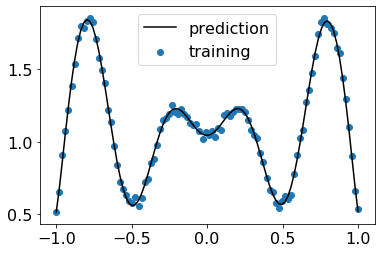

In [15]:
plt.figure()
plt.scatter(x, y, label='training')
plt.plot(x, lr.predict(x), label='prediction', c='k')
plt.legend()

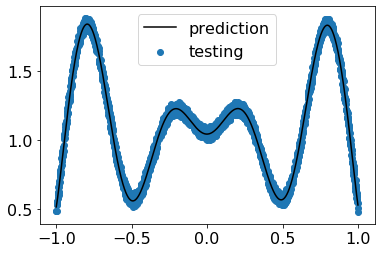

In [16]:
plt.figure()
plt.scatter(x_val, y_val, label='testing')
plt.plot(x_val, lr.predict(x_val), label='prediction', c='k')
plt.legend()

Text(0.5, 1.0, 'training set difference')

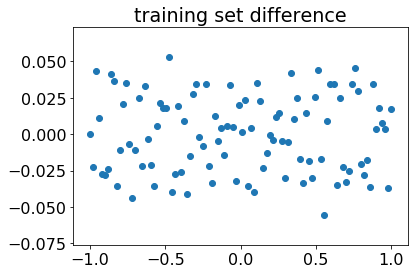

In [17]:
plt.figure()
plt.scatter(x, y - lr.predict(x))
plt.title("training set difference")

Text(0.5, 1.0, 'validation set difference')

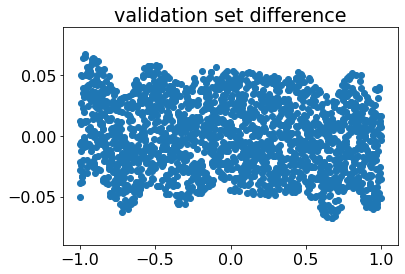

In [18]:
plt.figure()
plt.scatter(x_val, y_val - lr.predict(x_val))
plt.title("validation set difference")

# loop over deg and find best deg

In [19]:
def find_simplest_fit(X, y, degs, output_best=False, validation_data=None, method='sum-of-squares', verbose=True):
    """
    X, y data to fit
    degs: array of polynomial degrees to try
    
    returns a bunch of stuff included the prefereed degree
    according to min([AIC, AICc, BIC])
    
    if output_best=True
    then you will simply get the best fit
    
    """
    if validation_data:
        Xval, yval = validation_data
        # validation losses and info crit
        v_losses = []
        v_AICs = []
        v_AICcs = []
        v_BICs = []
        
    lrs = []
    # training and info crit
    t_losses = []
    t_AICs = []
    t_AICcs = []
    t_BICs = []

    for deg in degs:
        lr = fits.poly.LinearPolynomialBasisRegression()
        lr.fit(X, y, maxdegs=[deg])        
        tloss, [taic, taicc, tbic] = lr.loss(X, y, method=method, return_information_criteria=True)
        t_losses.append(tloss)
        t_AICs.append(taic)
        t_AICcs.append(taicc)
        t_BICs.append(tbic)
        
        min_t_AICs = np.argmin(t_AICs)
        min_t_AICcs = np.argmin(t_AICcs)
        min_t_BICs = np.argmin(t_BICs)        
        
        lrs.append(lr)
        
        if validation_data:
            vloss, [vaic, vaicc, vbic] = lr.loss(Xval, y_val, method=method, return_information_criteria=True)
            v_losses.append(vloss)
            v_AICs.append(vaic)
            v_AICcs.append(vaicc)
            v_BICs.append(vbic)        
            min_v_AICs = np.argmin(v_AICs)
            min_v_AICcs = np.argmin(v_AICcs)
            min_v_BICs = np.argmin(v_BICs)


    lowest_deg_t = min([min_t_AICs, min_t_AICcs, min_t_BICs])
    lowest_loss_t = np.min(t_losses)
    
    if verbose:
        print(f"lowest_deg for training set = {lowest_deg_t}")
        print(f"lowest loss for training set = {lowest_loss_t}")

    if validation_data:
        lowest_deg_v = min([min_v_AICs, min_v_AICcs, min_v_BICs])
        lowest_loss_v = np.min(v_losses)
        
        if verbose:
            print(f"lowest_deg for validation set = {lowest_deg_v}")     
            print(f"lowest loss for validation set = {lowest_loss_v}")

    if output_best:
        return lrs[lowest_deg_t]
    
            
    if validation_data:
        return lrs[lowest_deg_t], lrs, (lowest_deg_t, t_losses, t_AICs, t_AICcs, t_BICs), (lowest_deg_v, v_losses, v_AICs, v_AICcs, v_BICs)
    else:
        return lrs[lowest_deg_t], lrs, (lowest_deg_t, t_losses, t_AICs, t_AICcs, t_BICs)


In [20]:
max_degs = fits.poly.generate_degrees([60], max_deg_total=None)

In [21]:
best_lr, best_deg_idx, lrs, (lowest_deg_t, t_losses, t_AICs, t_AICcs, t_BICs), (lowest_deg_v, v_losses, v_AICs, v_AICcs, v_BICs) = \
    fits.poly.findpolyfit(x, y, max_degs=max_degs, validation_data=(x_val, y_val))

lowest_deg for training set = 14
lowest loss for training set = 0.019250683115105596
lowest_deg for validation set = 14
lowest loss for validation set = 0.894025438630134


In [22]:
best_lr, best_deg_idx, lrs, (lowest_deg_t, t_losses, t_AICs, t_AICcs, t_BICs) = \
    fits.poly.findpolyfit(x, y, max_degs=max_degs)

lowest_deg for training set = 14
lowest loss for training set = 0.019250683115105596


In [23]:
best_lr, best_deg_idx = \
    fits.poly.findpolyfit(x, y, max_degs=max_degs, output_best=True)

lowest_deg for training set = 14
lowest loss for training set = 0.019250683115105596


In [24]:
best_lr.w_ml.shape

(15,)

Text(0.5, 1.0, 'training set')

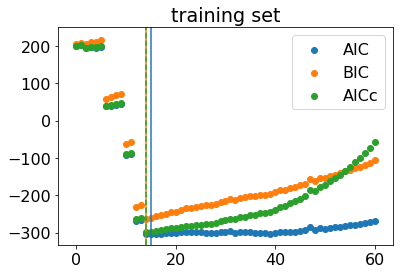

In [25]:
plt.figure()
plt.scatter(range(len(t_AICs)), t_AICs, label='AIC')
plt.scatter(range(len(t_AICs)), t_BICs, label='BIC')
plt.scatter(range(len(t_AICs)), t_AICcs, label='AICc')

plt.axvline(np.argmin(t_AICs), c='C0')
plt.axvline(np.argmin(t_BICs), c='C1')
plt.axvline(np.argmin(t_AICcs), ls='--', c='C2')

plt.legend()
plt.title('training set')

Text(0.5, 1.0, 'validation set')

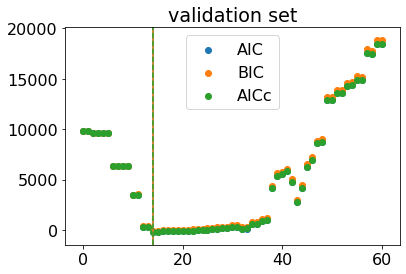

In [26]:
plt.figure()
plt.scatter(range(len(t_AICs)), v_AICs, label='AIC')
plt.scatter(range(len(t_AICs)), v_BICs, label='BIC')
plt.scatter(range(len(t_AICs)), v_AICcs, label='AICc')

plt.axvline(np.argmin(v_AICs), c='C0')
plt.axvline(np.argmin(v_BICs), c='C1')
plt.axvline(np.argmin(v_AICcs), ls='--', c='C2')

plt.legend()
plt.title('validation set')

Text(0, 0.5, '$loss$')

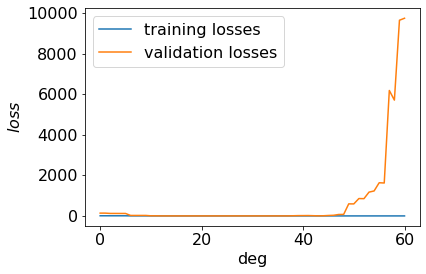

In [27]:
plt.figure()
plt.plot(range(len(t_AICs)), t_losses, label='training losses')
plt.plot(range(len(t_AICs)), v_losses, label='validation losses')
plt.legend()
plt.xlabel('deg')
plt.ylabel(r'$loss$')

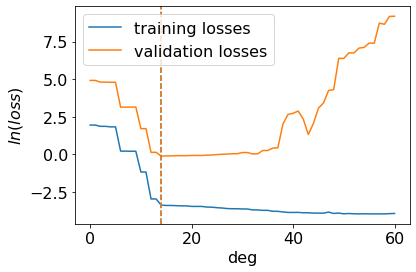

In [28]:
plt.figure()
plt.plot(range(len(t_AICs)), np.log(t_losses), label='training losses')
plt.plot(range(len(t_AICs)), np.log(v_losses), label='validation losses')
plt.legend()
plt.xlabel('deg')
plt.ylabel(r'$ln(loss)$')

plt.axvline(lowest_deg_t, c='C0', ls='--')
plt.axvline(lowest_deg_v, c='C1', ls='--')


In [29]:
tloss = best_lr.loss(x, y, method='sum-of-squares')
vloss = best_lr.loss(x_val, y_val, method='sum-of-squares')

In [30]:
print(tloss)

0.034531461986562983


In [31]:
print(vloss)

0.894025438630134


In [32]:
%%timeit
best_lr.predict(x_val[0].reshape(-1,1))

126 µs ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


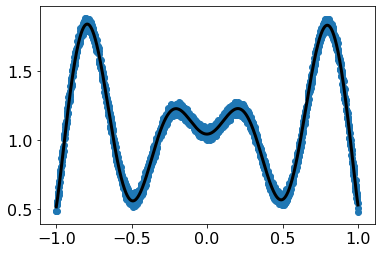

In [33]:
plt.figure()
plt.scatter(x_val, y_val, label='validation')
plt.plot(x_val, best_lr.predict(x_val), lw=3, c='k', label='final fit')

# try scaled data

# scale data

In [34]:
X_scaled, y_scaled, Xval_scaled, yval_scaled = fits.scale.scale_data(x, y, (x_val, y_val))

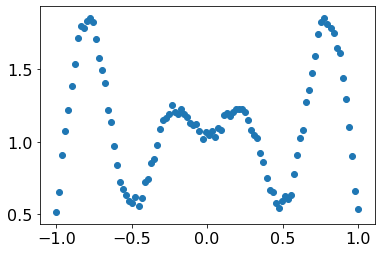

In [35]:
plt.figure()
plt.scatter(x, y)

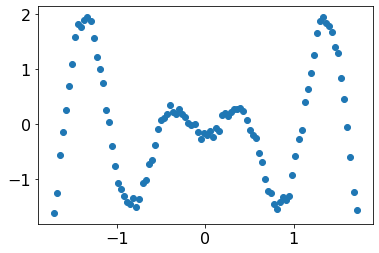

In [36]:
plt.figure()
plt.scatter(X_scaled, y_scaled)

In [37]:
max_degs = fits.poly.generate_degrees([60], max_deg_total=None)

In [38]:
best_lr, best_deg_idx, lrs, (lowest_deg_t, t_losses, t_AICs, t_AICcs, t_BICs), (lowest_deg_v, v_losses, v_AICs, v_AICcs, v_BICs) = \
    fits.poly.findpolyfit(X_scaled, y_scaled, max_degs=max_degs, validation_data=(Xval_scaled, yval_scaled))

lowest_deg for training set = 14
lowest loss for training set = 0.15844759708866613
lowest_deg for validation set = 14
lowest loss for validation set = 6.337561594779029


Text(0.5, 1.0, 'training set')

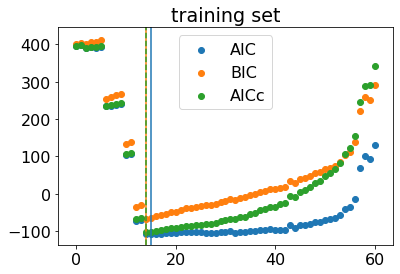

In [39]:
plt.figure()
plt.scatter(range(len(t_AICs)), t_AICs, label='AIC')
plt.scatter(range(len(t_AICs)), t_BICs, label='BIC')
plt.scatter(range(len(t_AICs)), t_AICcs, label='AICc')

plt.axvline(np.argmin(t_AICs), c='C0')
plt.axvline(np.argmin(t_BICs), c='C1')
plt.axvline(np.argmin(t_AICcs), ls='--', c='C2')

plt.legend()
plt.title('training set')

Text(0.5, 1.0, 'validation set')

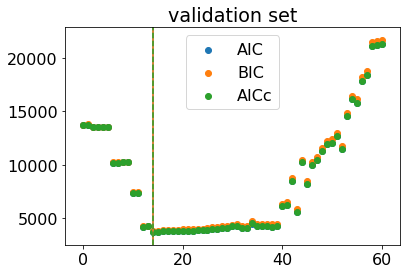

In [40]:
plt.figure()
plt.scatter(range(len(t_AICs)), v_AICs, label='AIC')
plt.scatter(range(len(t_AICs)), v_BICs, label='BIC')
plt.scatter(range(len(t_AICs)), v_AICcs, label='AICc')

plt.axvline(np.argmin(v_AICs), c='C0')
plt.axvline(np.argmin(v_BICs), c='C1')
plt.axvline(np.argmin(v_AICcs), ls='--', c='C2')

plt.legend()
plt.title('validation set')

Text(0, 0.5, '$loss$')

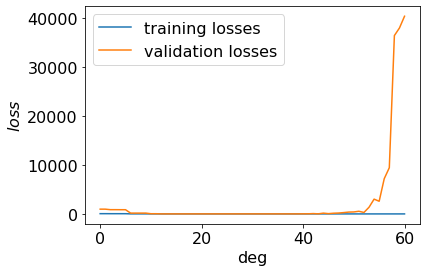

In [41]:
plt.figure()
plt.plot(range(len(t_AICs)), t_losses, label='training losses')
plt.plot(range(len(t_AICs)), v_losses, label='validation losses')
plt.legend()
plt.xlabel('deg')
plt.ylabel(r'$loss$')

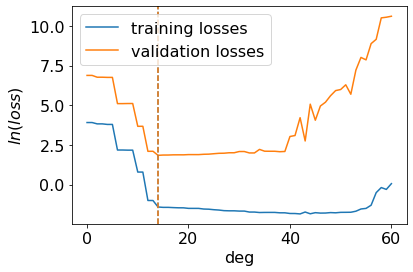

In [42]:
plt.figure()
plt.plot(range(len(t_AICs)), np.log(t_losses), label='training losses')
plt.plot(range(len(t_AICs)), np.log(v_losses), label='validation losses')
plt.legend()
plt.xlabel('deg')
plt.ylabel(r'$ln(loss)$')

plt.axvline(lowest_deg_t, c='C0', ls='--')
plt.axvline(lowest_deg_v, c='C1', ls='--')


In [43]:
tloss = best_lr.loss(X_scaled, y_scaled, method='sum-of-squares')
vloss = best_lr.loss(Xval_scaled, yval_scaled, method='sum-of-squares')

In [44]:
print(tloss)

0.24478639850903036


In [45]:
print(vloss)

6.337561594779029


In [46]:
%%timeit
best_lr.predict(Xval_scaled[0].reshape(-1,1))

128 µs ± 8.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


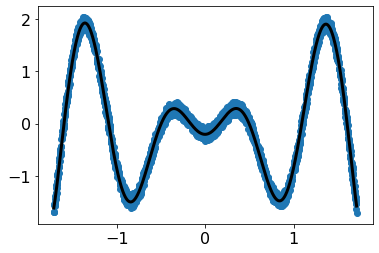

In [47]:
plt.figure()
plt.scatter(Xval_scaled, yval_scaled, label='validation')
plt.plot(Xval_scaled, best_lr.predict(Xval_scaled), lw=3, c='k', label='final fit')